In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import time

# Simple function to Maximimze

1.988950304427771


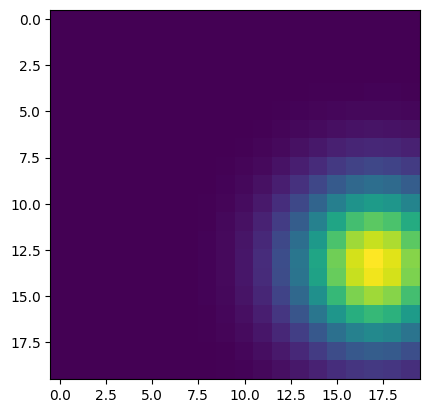

1.9889503044278196


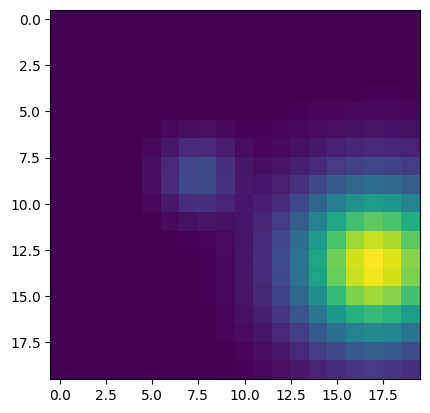

In [2]:
def hard(x,y):
    """Function with a maximum near (-1,-0.5) and a global maximum at (4,2)
    Inputs:
        x (float) - x coordinate
        y (float) - y coordinate
    Outputs:
        (float) - height h(x,y)
    
    """
    return 2*np.exp(-((x-4)**2+(y-2)**2)/5)+0.5*np.exp(-(x+1)**2-(y+0.5)**2)

def easy(x,y):
    """Function with a global maximum at (4,2)
    
    Inputs:
        x (float) - x coordinate
        y (float) - y coordinate
    Outputs:
        (float) - height h(x,y)
    
    """
    return 2*np.exp(-((x-4)**2+(y-2)**2)/5)

X,Y=np.meshgrid(*[np.linspace(-5,5,20)]*2)
plt.imshow(easy(X,Y))

print(np.max(easy(X,Y)))
plt.show()

plt.imshow(hard(X,Y))

print(np.max(hard(X,Y)))

# Discrete gym for maximizing the function

In [3]:
class MaxGym(gym.Env):
    def __init__(self,function=easy,length=100):
        """
        We define the action and observation space here
        
        Actions are an integer from 1 to 9 representing a discrete joystick for movement in 2D
        
        Observations are two floating points representing your current position
        
        """
        
        self.length=length
        
        #action space setup
        self.xadd= [0,     -0.1,-0.02,0.02,0.1,0,   0,    0,   0  ]
        self.yadd= [0,     0,   0,    0,   0,  -0.1,-0.02,0.02,0.1]
        
        #Set the action and observation space
        self.observation_space = spaces.Box(low=-5,high=5,shape=[2],dtype='float')
        self.action_space= spaces.Discrete(9)
        #distance is used in reward calculation
        self.height=0
        self.f=function
        self.reset()
        
    def step(self,action):
        """
        Update the environment by performing an action.

        Inputs:
            action (int) - index of the action to perform.
                Action:         [0,     1,      2,      3,      4,      5,      6,      7,      8]
                Add to X:       [0,     -0.1,   -0.02,  0.02,   0.1,    0,      0,      0,      0]
                Add to Y:       [0,     0,      0,      0,      0,      -0.1,   -0.02,  0.02, 0.1]
        
        Outputs:
            state - shape [2] numpy array
                A numpy array containing state variables.
            reward (float) - reward given during this timestep
                The amount of reward generated in perfoming the action.
            done (bool) - Whether or not the final state has been reached and the episode is completed
            params (dict) - unused
        """
        self.idx+=1
        #action gives change to inverse temp and mew
        self.x+=self.xadd[action]
        self.y+=self.yadd[action]
        #keep temperature and field strength within reasonable limits
        self.x=max(min(self.x,5.0),-5.0)
        self.y=max(min(self.y,5.0),-5.0)
        
        outstate = np.array([self.x,self.y])
        #get new evaluation
        oldheight=self.height
        self.height=self.f(self.x,self.y)
            
        return outstate, self.height-oldheight, self.idx>=self.length, {}
          
    def reset(self):
        '''
        Initialize the environment. This sets the x and y position back to 0
        Outputs:
            state - shape [2] numpy array
        '''
        #reset the position
        self.x=self.y=self.idx=0
        #self.rew actually just tells you the return of the last episode and is used for debugging
        self.rew=self.height
        #reset the distance from the target point
        self.height=0
        #generate a random accessable point in phase space
        outstate = np.array([self.x,self.y])
        
        return outstate
    def render(self,mode="human"):
        """Render the Environment"""
        X,Y=np.meshgrid(*[np.linspace(-5.2,5.2,20)]*2)
        plt.imshow(self.f(X,Y))
        plt.plot(self.x*(10/5.2)+9.5,self.y*(10/5.2)+9.5,"r.")
        plt.axis("off")
        plt.show()
        


In [4]:
#register this as an environment (note the entry point will be different if made in a package)        
gym.envs.register(
     id="MaxGymEasy-v0",
     entry_point='__main__:MaxGym',
     kwargs={'function':easy},
)
gym.envs.register(
     id="MaxGymHard-v0",
     entry_point='__main__:MaxGym',
     kwargs={'function':hard},
)

# Baselines Example

Here we do the following steps:

1. Create the easy gym
2. Wrap it with a baselines monitor so we can plot the returns
3. Train a DQN agent for 200 000 timesteps
4. Conduct a 10 episode rollout of the environment
5. Plot the training results

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1532     |
|    time_elapsed     | 65       |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.58e-05 |
|    n_updates        | 12499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1070     |
|    time_elapsed     | 186      |
|    total_timesteps  | 200000   |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

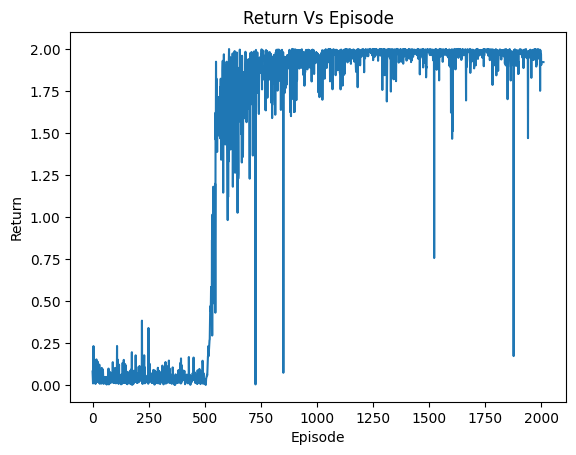

In [5]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

#Instantiate the easy environment
env = gym.make("MaxGymEasy-v0")

m_env = Monitor(env)

# Instantiate the agent
model = DQN("MlpPolicy", m_env, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e5),log_interval=int(1e3))

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

print(mean_reward,std_reward)

plt.plot(m_env.get_episode_rewards())
plt.title("Return Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

# Training the more difficult gym:

Same 5 steps but with MaxGymHard which has a local maximum

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 0.179    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 978      |
|    time_elapsed     | 204      |
|    total_timesteps  | 200000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00158  |
|    n_updates        | 37499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | 0.937    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 853      |
|    time_elapsed     | 468      |
|    total_timesteps  | 400000   |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

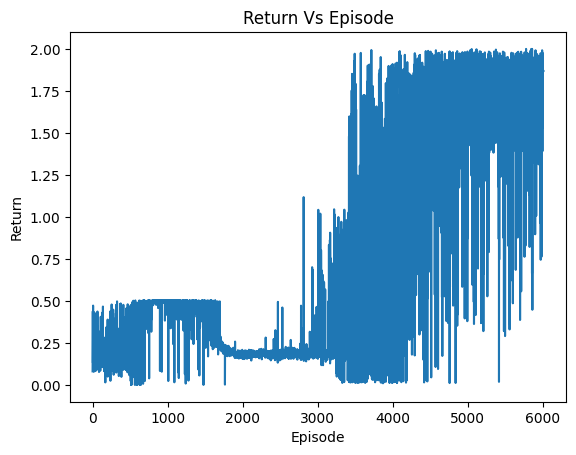

In [5]:
#Instantiate the more difficult environment
env = gym.make("MaxGymHard-v0")
m_env = Monitor(env)

# Instantiate the agent
model = DQN("MlpPolicy", m_env, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(6e5),log_interval=int(2e3))

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

print(mean_reward,std_reward)

plt.plot(m_env.get_episode_rewards())
plt.title("Return Vs Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

# Custom RL Example
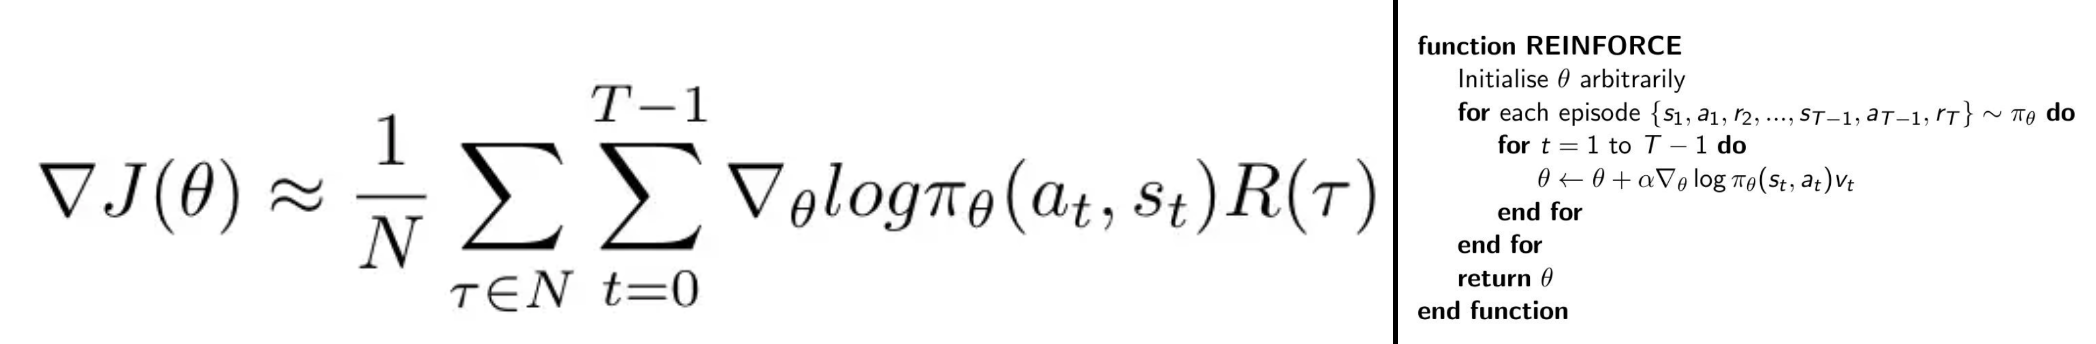

In [14]:
import torch
from torch import nn

In [20]:
class MLPolicy(nn.Module):
    """
    Example policy for a reinforcement learning agent. This policy uses two fully connected layers and takes in an observation (vector of shape [2])
    and returns a probability of taking each of the 9 possible actions (using softmax).
    
    """
    def __init__(self):
        super(MLPolicy, self).__init__()
        self.lin = nn.Sequential(
                nn.Linear(2,32),
                nn.ReLU(),
                nn.Linear(32,32),
                nn.ReLU(),
                nn.Linear(32,9),
                nn.Softmax(dim=-1)
            )
    def forward(self,obs):
        """Takes in an observation and returns an action along with it's probability
        Inputs:
            obs - Numpy array of shape [2] representing an observation
        Outputs:
            act (int) - number from 0 to 8 represting a sampled action
            probs - a shape [9] array representing the probabilities from which the action was sampled
        """
        probs=self.lin(torch.Tensor(obs))
        #adding in random actions which aren't reflected in the gradient
        rndprobs = probs*0.95+0.05/9
        act = torch.multinomial(rndprobs,1,False)
        return act.item(),probs[act]

In [21]:
def ascent(theta,alpha):
    """
    Optimizer function which takes a set of parameters, updates them with gradient ascent according to their gradients
    and an update constant alpha, then sets the gradients to 0
    
    Inputs:
        theta - a tuple of pytorch parameters with gradients
        alpha (float) - the update constant
    """
    for param in theta():
        #add gradients multiplied by the learning rate alpha
        param.data.copy_(param.data+alpha*param.grad.data)
        #zero your gradients
        param.grad.data.zero_()

In [22]:
def REINFORCE(env,policy,B=100,epochs=100,alpha=0.1):
    """Simple implementation of the REINFORCE algorithm. Conceptually, you want to maximize the probability of 
    actions which led to high rewards. Here the policy is updated by collecting experiences from the environment.
    Reinforce is offline so we collect a set (size B) of episodes in order to update our policy
    
    Inputs:
        env (gym.Env) - a gym which we want to maximize the reward of
        policy (nn.Module) - a policy we want to optimize for the environment
        B (int) - Number of episodes to collect before doing a gradient update
        epochs (int) - the total number of gradient updates to perform
    
    Note: This can be improved by keeping an experience replay and re-labeling the probability of taking actions to reuse
    experiences when training an updated policy.
    
    """
    Returns=[]
    for step in range(epochs):
        logp=torch.zeros(B)
        R=torch.zeros(B)
        #collect your trajectories
        for b in range(B):
            obs,done=env.reset(),False
            while not done:
                act,p = policy(obs)
                obs,r,done,_=env.step(act)
                logp[b:b+1]+=torch.log(p)
                R[b]+=r
                
        #Used to get gradients on the objective function
        Jhelper= (R*logp).mean()
        #Compute objective function gradients
        Jhelper.backward()
        #Perform gradient ascent
        ascent(policy.parameters,alpha)
        Returns+=[R.mean().item()]
    return Returns

396.9371120929718


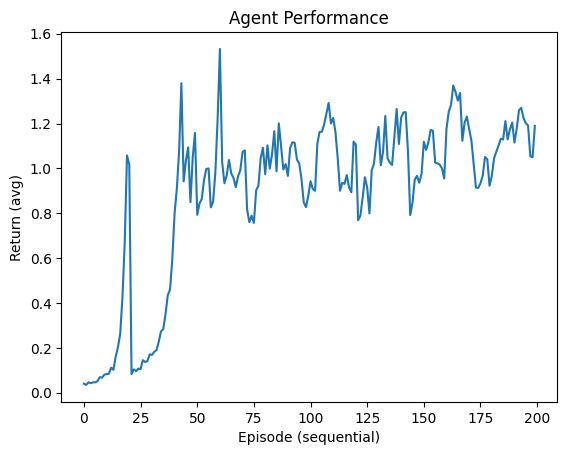

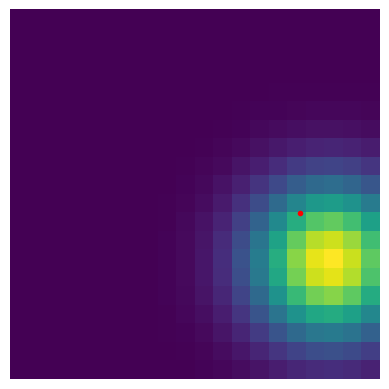

In [23]:
policy = MLPolicy()
env=gym.make("MaxGymEasy-v0")
t=time.time()
ret = REINFORCE(env,policy,B=50,epochs=200)
print(time.time()-t)

plt.plot(ret)
plt.title("Agent Performance")
plt.ylabel("Return (avg)")
plt.xlabel("Episode (sequential)")
plt.show()

env.render()

401.7870044708252


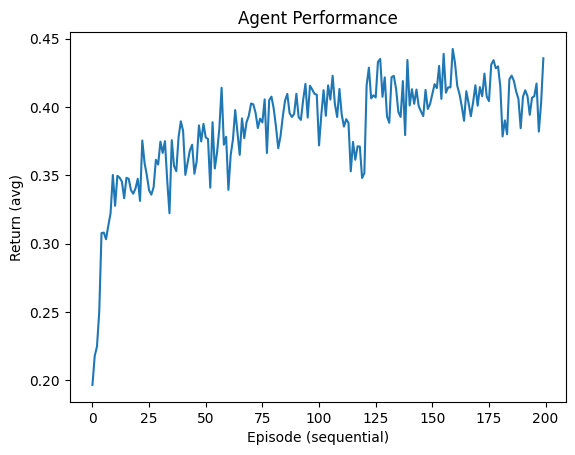

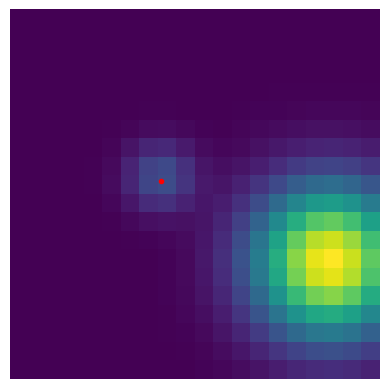

In [24]:
policy2 = MLPolicy()
env=gym.make("MaxGymHard-v0")
t=time.time()
ret = REINFORCE(env,policy2,B=50,epochs=200)
print(time.time()-t)

plt.plot(ret)
plt.title("Agent Performance")
plt.ylabel("Return (avg)")
plt.xlabel("Episode (sequential)")
plt.show()

env.render()

In [12]:
!pip freeze

anyio @ file:///C:/ci/anyio_1644463701441/work/dist
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569878360/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
Babel @ file:///C:/b/abs_a2shv_3tqi/croot/babel_1671782804377/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ file:///C:/ci/beautifulsoup4_1650274792587/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
brotlipy==0.7.0
certifi @ file:///C:/b/abs_85o_6fm0se/croot/certifi_1671487778835/work/certifi
cffi @ file:///C:/b/abs_49n3v2hyhr/croot/cffi_1670423218144/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
cloudpickle==2.2.1
colorama @ file:///C:/b/abs_a9ozq0l032/croot/colorama_1672387194846/work
comm @ file:///C:/b/abs_1419earm7u/croot/comm_1671231131638/wor